# Inference and Spherical Coding (First Order Model)

This notebook serves the same purpose as the spherical_code3.ipynb notebook, but a first-order dynamic system is used instead of linear functional decomposition. The advantage of introducing a model is to circumvent the fixed-length basis problem, which requires some sort of extrapolation.

The model parameters can also be learnt by some adaptive methods, which is still a subject for further research.

# Load the trajectory data, as usual

In [1]:
import numpy as np
import pickle 
from matplotlib import pyplot as plt 
trajectory_file = open("trajectories.pyo", "rb")
trajs = pickle.load(trajectory_file)
y_vec = np.array(trajs['y_vec'])
t_vec = np.array(trajs['t_vec'])
del trajs
trajectory_file.close()
del trajectory_file

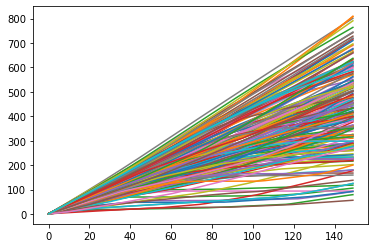

In [2]:
for traj in range(y_vec.shape[0]):
    plt.plot(y_vec[traj])

# Setup the model

Distribution $p(\alpha, u)$, assumed to be a multivariate Gaussian, defined by the mean $\mu_{\alpha, u}$ and $\Sigma_{\alpha, u}$.

The following function calculates $p(y_{1:n}|u,\alpha)$:

In [3]:
# To calculate likelihood for the entire observation stream
# from scipy.stats import norm, multivariate_normal
# def likelihood_y_over_ua(y_vec, u, alpha, y1, v1, T, info_e):
#     length_of_yvec = np.shape(y_vec)[0]
#     v1_coefficient = 0
#     u_coefficient = 0
#     log_llh = 0
#     for k in range(2, length_of_yvec): # 2 to length_of_yvec
#         v1_coefficient = v1_coefficient + pow(alpha, k-2)
#         for j in range(0, k-1): # 0 to k-2
#             u_coefficient = u_coefficient + pow(alpha, j)
#         # now v1_coefficient and u_coefficient are ready
#         yk_hat = y1 + T * v1_coefficient * v1 + T * u_coefficient * u
#         yk = y_vec[k]
#         # calculate the log likelihood
#         log_llh = log_llh + info_e * (yk_hat - yk)**2
#     return log_llh

This function predicts y from alpha, u, v1, y1:

In [4]:
def get_yk(alpha, u, v1, y1, k, T):
    u_coefficient = 0
    v1_coefficient = 0
    for i in range(0,k-1): # 0 to k-2
        v1_coefficient = v1_coefficient + pow(alpha, i)
    for i in range(0, k): # 0 to k-1
        for j in range(0,i-1): # 0 to i-2
            u_coefficient = u_coefficient + pow(alpha, j)
    # now v1_coefficient and u_coefficient are ready
    yk_hat = y1 + T * v1_coefficient * v1 + T * u_coefficient * u
    return yk_hat

Calculating the likelihood

In [5]:
# To calculate likelihood for one observation at time k
from scipy.stats import norm, multivariate_normal
def likelihood_y_over_ua(y, k, u, alpha, y1, v1, T, info_e):
    yk_hat = get_yk(alpha, u, v1, y1, k, T)
    # print('yk_hat: {} - y: {}'.format(yk_hat, y))
    # calculate the log likelihood
    # print('yk_hat = {} - yk = {}'.format(yk_hat, yk))
    return info_e * (yk_hat - y)**2

## Unit tests

We take the opportunity to write the code to generate a series of y from u and alpha, since it is similar to the above function:

In [6]:
def gen_y_from_ua(length_of_yvec, u, alpha, y1, v1, T):
    y_gen = np.zeros((length_of_yvec,))
    y_gen[0] = y1 
    # y_gen[1] = y1 + T*v1 
    for k in range(2, length_of_yvec+1): # 2 to length_of_yvec
        yk_hat = get_yk(alpha, u, v1, y1, k, T)
        y_gen[k-1] = yk_hat
    return y_gen

$\mu_{\alpha, u}$ and $\Sigma_{\alpha, u}$:

In [7]:
# mu_au = np.array([0.95, 3.5]) # mean of alpha and u respectively
# cov_au = np.array([[0.05, 0],[0, 1.0]]) # the covariance matrix of alpha and u

Unit test for the gen_y_from_ua function: generate a time series of $y$ from $u, \alpha$:

In [8]:
# y_gen_test = gen_y_from_ua(length_of_yvec=100, u=2.5, alpha=0.9, y1=0, v1=0, T=0.1)

In [9]:
# plt.subplot(2,1,1)
# plt.plot(y_gen_test)
# plt.subplot(2,1,2)
# plt.plot(np.diff(y_gen_test))

Unit test for the likelihood calculation function: likelihood_y_over_ua

In [10]:
# y_gen_test = gen_y_from_ua(length_of_yvec=100, u=2.5, alpha=0.85, y1=0, v1=0, T=0.1)
# y_gen_ref = gen_y_from_ua(length_of_yvec=100, u=2.5, alpha=0.9, y1=0, v1=0, T=0.1)
# plt.plot(y_gen_ref, 'b')
# plt.plot(y_gen_test, 'g')
# plt.legend(['Reference', 'Observation'])
# print('Log-likelihood: {:.2f}'.format(likelihood_y_over_ua(y_gen_test, u=2.5, alpha=0.9, y1=0, v1=0, T=0.1, info_e=1)))

# Particle Filter

We start with a particle filter implementation to estimate $\alpha^*$ and $u$ from the stream of observations.

Get one trajectory to test the algorithm:

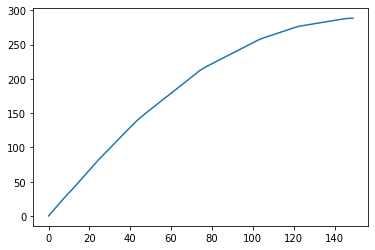

In [11]:
y_test = y_vec[20]
y_length = y_test.shape[0]
plt.plot(y_test)

Particle filter

Here is the resampling code for the particle filter

In [12]:
# Low variance resampling
def lvr(particles, weights): # requires normalized weights first
    # return: new particles with equal weights
    M = particles.shape[0] # number of particles
    new_particles = np.zeros_like(particles)
    # new_particles_weight = np.ones((M,)) / M 
    # W = np.sum(weights)
    r = np.random.rand() / M # get a random number between 0 and 1/M
    c = weights[0]
    i = 0
    for m in range(M):
        U = r + m/M
        while U>c:
            i+=1
            c+=weights[i]
        new_particles[m] = particles[i]
    return new_particles


In [21]:
mu_au = np.array([0.5, 20]) # mean of alpha and u respectively
cov_au = np.array([[0.25, 0],[0, 20]]) # the covariance matrix of alpha and u

n_particles = 8000 
map_particle_available = False

# Step 1: generate a bunch of particles from the prior distribution
particles = multivariate_normal.rvs(mean=mu_au, cov=cov_au, size=n_particles, random_state=6969)
weights = np.ones((n_particles,)) / n_particles

n_window = 30 # the look back window to infer alpha and u
map_components_log = np.zeros((y_test.shape[0], particles.shape[1]))
u_init = mu_au[1]
alpha_init = mu_au[0]
v1_init = u_init / (1-alpha_init)
weights_variance_log = np.zeros((y_test.shape[0],))
measurement_likelihood_log = np.zeros((y_test.shape[0],))
error_log = np.zeros((y_test.shape[0],))
broadcast_log = np.zeros((y_test.shape[0],))

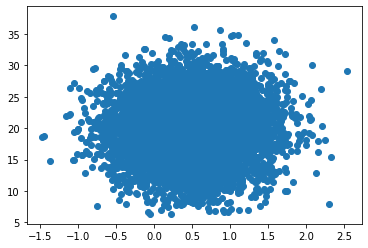

In [22]:
plt.scatter(particles[:,0], particles[:,1])

In [23]:
map_at_client = None
y1_at_client = None 
v1_at_client = None 
k_at_client = None

# for t in range(n_window, y_length):
for t in range(49, 140):
    # When measurement arrives, calculate the importance weights first
    weights_normalization_coeff = 0
    observation_starts_from = t - n_window
    observation_ends_at = t
    weights = np.ones((n_particles,)) / n_particles
    for k in range(n_window):
        # print('Adding measurement {:d}'.format(observation_starts_from + k))
        for j in range(weights.shape[0]): # loop over all particles
            # v1 should be replaced by the last of vk from the particle filter
            measurement_likelihood = likelihood_y_over_ua(y = y_test[observation_starts_from + k], k=k+1, u=particles[j,1], alpha=particles[j,0], y1=y_test[observation_starts_from], v1=v1_init, T=.1, info_e=1)
            weights[j] += measurement_likelihood
            weights_normalization_coeff += weights[j]
            measurement_likelihood_log[t] += measurement_likelihood

        # print(t, measurement_likelihood)

    # Normalization all the weights
    # for j in range(weights.shape[0]):
    #     weights[j] = weights[j] / weights_normalization_coeff
    
    # Continuously update the MAP
    map_particle_index = np.argmin(weights)
    map_particle_value = particles[map_particle_index]
    # Broadcast a message to all receivers at the beginning of the observation
    if map_at_client is None: 
        map_at_client = map_particle_value.copy() 
        y1_at_client = y_test[observation_starts_from]
        v1_at_client = v1_init 
        k_at_client = n_window - 1
    # Calculate the prediction (what the client should know if we refrain from broadcasting)
    k_at_client += 1
    yk_at_client = get_yk(alpha=map_at_client[0], u=map_at_client[1], v1=v1_at_client, y1=y1_at_client, k=k_at_client+1, T=0.1)
    if yk_at_client - y_test[t] > 3: # if the error is larger than the threshold of 3ft
        print('Broadcast at t={:d}, TSLB: {:d}'.format(t, k_at_client - n_window))
        map_at_client = map_particle_value.copy() 
        y1_at_client = y_test[observation_starts_from]
        v1_at_client = v1_init 
        k_at_client = n_window - 1
    else:
        print('Error at t={:d} is {:.2f}'.format(t, yk_at_client - y_test[t]))
    # print(t, map_particle_value)
    map_components_log[t,:] = map_particle_value
    map_particle_available = True
    alpha_est = map_particle_value[0]
    u_est = map_particle_value[1]
    v1_init = u_est/(1-alpha_est)

    # When measurements arrive, we calculate the error between the measurement and the prediction by the previous MAP
    
    
    # print('vi_init', v1_init, '\n ===')
    # error_log[t] = np.abs(((map_particle_value) @ friendly_basis)[t] - y_test[t])
        
    # # Resample the particles according to the particle weights
    # if measurement_likelihood_log[t] < 100:
    #     particles = lvr(particles, weights)
    #     weights = np.ones((n_particles,)) / n_particles

    weights_variance_log[t] = np.var(weights)

Error at t=49 is 2.39
Error at t=50 is 2.99
Broadcast at t=51, TSLB: 2
Error at t=52 is 1.61
Error at t=53 is 2.28
Error at t=54 is 2.95
Broadcast at t=55, TSLB: 3
Error at t=56 is 1.54
Error at t=57 is 2.24
Error at t=58 is 2.95
Broadcast at t=59, TSLB: 3
Error at t=60 is 1.70
Error at t=61 is 2.13
Error at t=62 is 2.58
Broadcast at t=63, TSLB: 3
Error at t=64 is 0.61
Error at t=65 is 0.93
Error at t=66 is 1.25
Error at t=67 is 1.57
Error at t=68 is 1.89
Error at t=69 is 2.21
Error at t=70 is 2.53
Error at t=71 is 2.83
Broadcast at t=72, TSLB: 8
Error at t=73 is -1.85
Error at t=74 is -1.56
Error at t=75 is -1.12
Error at t=76 is -0.51
Error at t=77 is 0.27
Error at t=78 is 1.16
Error at t=79 is 2.07
Error at t=80 is 2.96
Broadcast at t=81, TSLB: 8
Error at t=82 is 2.14
Error at t=83 is 2.91
Broadcast at t=84, TSLB: 2
Error at t=85 is 2.93
Broadcast at t=86, TSLB: 1
Broadcast at t=87, TSLB: 0
Broadcast at t=88, TSLB: 0
Broadcast at t=89, TSLB: 0
Broadcast at t=90, TSLB: 0
Broadcast at

In [24]:
print('v1=', v1_at_client)
print('y1=', y1_at_client)
print('alpha=', map_at_client[0])
print('u=', map_at_client[1])
print('k=', k_at_client)
print('Observed: ', y_test[49-n_window:49])
print('Inferred latest: ', yk_at_client)
# ---
# Test the likelihood of two particles
w1=np.array([0.834673748812887, 8.437243685603304])
w2=np.array([0.0001, 30])
ww=np.zeros((2,))
for k in range(n_window):
        # print('Adding measurement {:d}'.format(observation_starts_from + k))
        for i,w in enumerate([w2]): # loop over all particles
            # v1 should be replaced by the last of vk from the particle filter
            measurement_likelihood = likelihood_y_over_ua(y = y_test[49-n_window + k], k=k+1, u=w[1], alpha=w[0], y1=y1_at_client, v1=v1_at_client, T=1, info_e=1)
            ww[i] += measurement_likelihood
            weights_normalization_coeff += weights[j]
            measurement_likelihood_log[t] += measurement_likelihood
print('Likelihood of particle 1: {} vs 2: {}'.format(ww[0], ww[1]))

v1= 8.64211676017962
y1= 261.368
alpha= -0.12372479095035704
u= 9.464675028166775
k= 31
Observed:  [ 63.51   66.863  70.214  73.575  76.949  80.297  83.552  86.673  89.654
  92.598  95.597  98.675 101.779 104.849 107.896 110.964 114.075 117.201
 120.297 123.341 126.346 129.345 132.356 135.348 138.242 140.986 143.604
 146.07  148.445 150.808]
Inferred latest:  287.49756956717
Likelihood of particle 1: 11254583.396820117 vs 2: 0.0


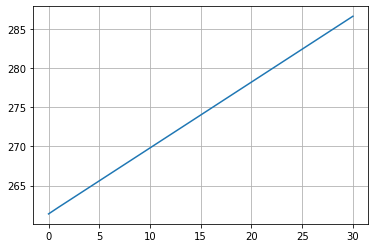

In [25]:
y_gen_test = np.zeros((n_window+1,))
for i in range(n_window+1):
    y_gen_test[i] = get_yk(alpha=map_at_client[0], u=map_at_client[1], v1=v1_at_client, y1=y1_at_client, k=i+1, T=0.1)
plt.plot(y_gen_test)
plt.grid(True)

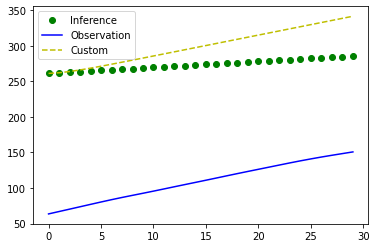

In [26]:
y_gen_test = gen_y_from_ua(length_of_yvec=n_window, alpha=map_at_client[0], u=map_at_client[1], y1=y1_at_client, v1=v1_at_client, T=.1)
y_gen_bel = gen_y_from_ua(length_of_yvec=n_window, u=12.37, alpha=0.58, y1=y1_at_client, v1=v1_at_client, T=0.1)
# y_gen_test = gen_y_from_ua(length_of_yvec=100, u=2.5, alpha=0.85, y1=0, v1=0, T=0.1)
y_gen_ref = y_test[49-n_window:49]
plt.plot(y_gen_test, 'go')
plt.plot(y_gen_ref, 'b')
plt.plot(y_gen_bel, 'y--')
plt.legend(['Inference', 'Observation', 'Custom'])
# print('Log-likelihood: {:.2f}'.format(likelihood_y_over_ua(y_gen_test, u=2.5, alpha=0.9, y1=0, v1=0, T=0.1, info_e=1)))

In [27]:
map_at_client

array([-0.12372479,  9.46467503])